## <span style="color:navy">  Exercise 7 - Molecular Dynamics in the canonical NVT </span>

The purpose of the following exercises is to explore the thermodynamical properties and their behaviour in the Molecular Dynamics of a canical ensemble. The exercise background is very similar to the one we studied in Exercises 4 for the Molecular Dynamics in a microcanonical NVE, but this time the implementation of the Move() function is different: since we are now in a system where the energy is free to vary, we will now use the Metropolis algorithm instead of the Verlet one, which is a proper choice in systems where the energy is constant.

## 7.1
In the NSL simulator code we have provided, include tail corrections for potential energy $U$ and pressure $P$.

In initialize.properties(), a method in system.cpp, we added the code to calculate p_tail and v_tail, which were previously set to zero.

## 7.2
In this first exercise we are asked to use the given NVT code in order to:

1) Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
    - solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
    - liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
    - gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

2) Compute the autocorrelation function of $U/N$ and $P$ and fit it with an exponential function in order to obtain the Monte Carlo correlation time $t_{c}$.

3) Study the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L= 5 * 10^{£}$, being $N$ the number of blocks.

### Equilibration

In order to evaluate the two thermodynamic properties, we firstly need to equilibrate the system. In order to do so we just need to run the Metropolis algorithm a certain number of MC time steps to reach stable output results. 
I have manually changed the input file setting M=1 and N=5000 in order to accomplish the output desired.
In order to obtain a Metropolis acceptance rate approximately $50%$, I manually set the MC step:

- $\delta_{solid}=0.1$
- $\delta_{liquid}=0.2$
- $\delta_{gas}=7.5$

I manage the phase input files thanks to a Python script.

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
from tqdm import tqdm

Esecuzione di ./simulator.exe...

Dati salvati in equilibrium_solid.dat


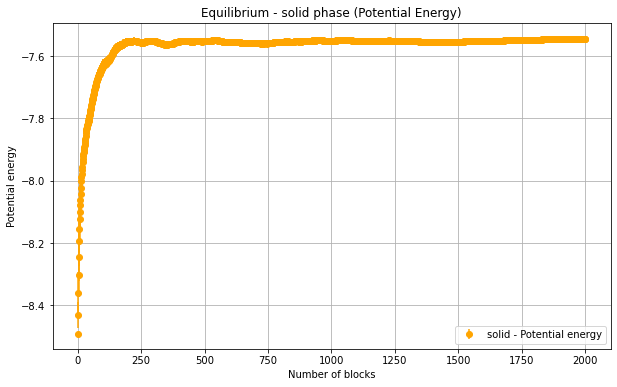

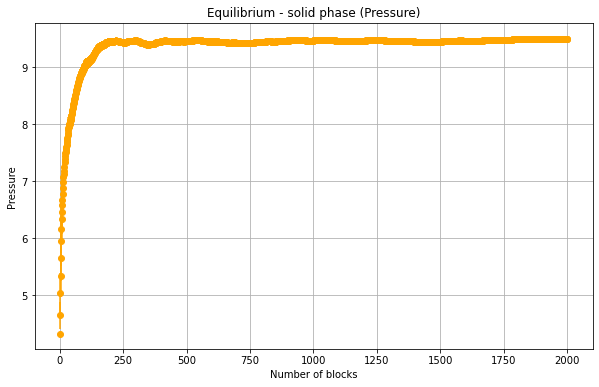

Esecuzione di ./simulator.exe...

Dati salvati in equilibrium_liquid.dat


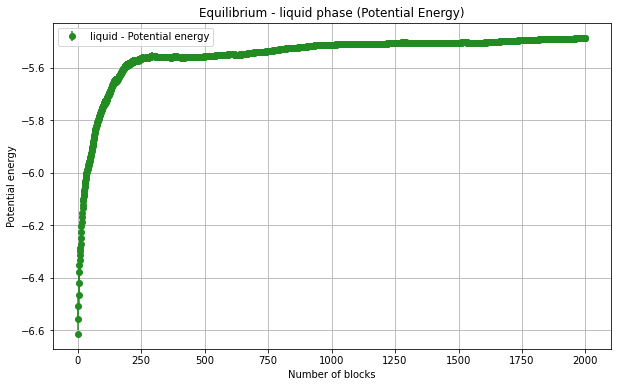

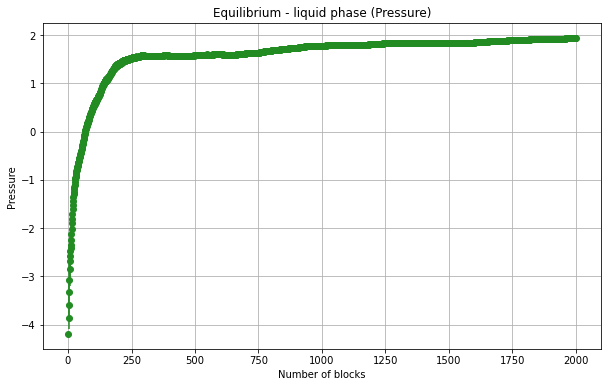

Esecuzione di ./simulator.exe...

Dati salvati in equilibrium_gas.dat


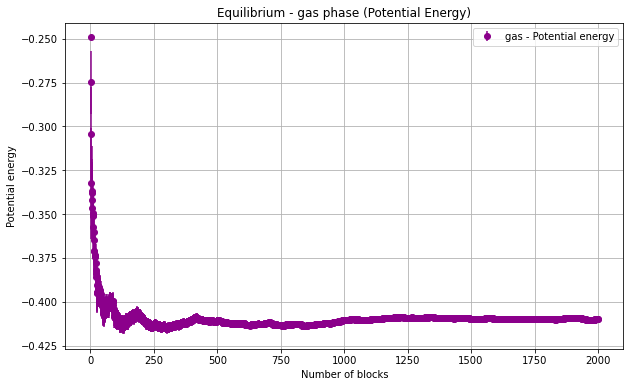

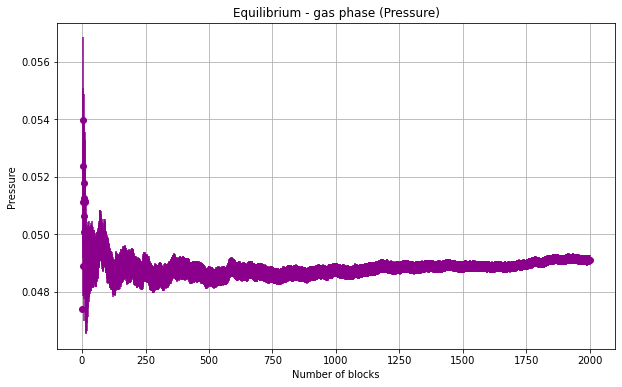

In [ ]:
import os
import matplotlib.pyplot as plt

def esegui_file_exe(percorso_exe):
    """Esegue un file .exe specificato."""
    if not os.path.exists(percorso_exe):
        print(f"Errore: Il percorso {percorso_exe} non esiste.")
        return False
    try:
        print(f"Esecuzione di {percorso_exe}...")
        result = subprocess.run(percorso_exe, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
        return True
    except subprocess.CalledProcessError as e:
        print(f"Errore durante l'esecuzione: {e.stderr.decode()}")
        return False

def modifica_parametro(file_path, parametro, nuovo_valore):
    """Modifica un parametro specificato in un file di input."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for i, line in enumerate(lines):
        if parametro in line:
            #print(f"Modifica parametro {parametro}: {line.strip()} -> {nuovo_valore}")
            lines[i] = f"{parametro} {nuovo_valore}\n"
            break
    with open(file_path, 'w') as file:
        file.writelines(lines)

def leggi_tutti_blocchi(percorso):
    """Legge tutti i valori e gli errori dai file di output con struttura specifica."""
    dati = []
    if not os.path.exists(percorso):
        print(f"Errore: Il file {percorso} non esiste.")
        return dati
    with open(percorso, 'r') as file:
        for line in file:
            if line.startswith("#") or not line.strip():
                continue  # Salta l'intestazione o righe vuote
            valori = line.split()
            if len(valori) >= 4:
                pe_ave = float(valori[2])  # Energia media
                errore = float(valori[3])  # Errore associato
                dati.append((pe_ave, errore))
    return dati

def simula_fase(fase, parametri, percorso_input, percorso_exe, percorsi_output, file_output):
    """Simula una fase specifica e salva tutti i dati di output."""
    for parametro, valore in parametri.items():
        modifica_parametro(percorso_input, parametro, valore)
    
    if not esegui_file_exe(percorso_exe):
        print(f"Simulazione per la fase {fase} fallita.")
        return None
    
    energia_blocchi = leggi_tutti_blocchi(percorsi_output['energia'])
    pressione_blocchi = leggi_tutti_blocchi(percorsi_output['pressione'])
    
    if not energia_blocchi or not pressione_blocchi:
        print(f"Errore: I dati per la fase {fase} non sono stati generati correttamente.")
        return None
    
    # Scrive i dati in un file di output specifico
    with open(file_output, 'w') as file:
        file.write("# Blocco\tEnergia Media\tErrore Energia\tPressione Media\tErrore Pressione\n")
        for i, ((energia, errore_energia), (pressione, errore_pressione)) in enumerate(zip(energia_blocchi, pressione_blocchi)):
            file.write(f"{i + 1}\t{energia}\t{errore_energia}\t{pressione}\t{errore_pressione}\n")
    
    print(f"Dati salvati in {file_output}")
    return energia_blocchi, pressione_blocchi

def plottare_dati(fase, file_dati, titolo_energia, titolo_pressione, output_plot_energia, output_plot_pressione, colore):
    """Plotta i dati di energia e pressione separatamente."""
    steps, energie, errori_energia, pressioni, errori_pressione = [], [], [], [], []
    with open(file_dati, 'r') as file:
        for i, line in enumerate(file.readlines()):
            if line.strip() and not line.startswith("#"):  # Ignora righe vuote o commenti
                valori = line.split()
                blocco = int(valori[0])
                energia, errore_energia = float(valori[1]), float(valori[2])
                pressione, errore_pressione = float(valori[3]), float(valori[4])
                steps.append(blocco)
                energie.append(energia)
                errori_energia.append(errore_energia)
                pressioni.append(pressione)
                errori_pressione.append(errore_pressione)
    
    # Plot Energia
    plt.figure(figsize=(10, 6))
    plt.errorbar(steps, energie, yerr=errori_energia, fmt='o', color=colore, label=f'{fase} - Potential energy')
    plt.title(titolo_energia)
    plt.xlabel("Number of blocks")
    plt.ylabel("Potential energy")
    plt.legend()
    plt.grid()
    plt.savefig(output_plot_energia)
    plt.show()
    
    # Plot Pressione
    plt.figure(figsize=(10, 6))
    plt.errorbar(steps, pressioni, yerr=errori_pressione, fmt='o', color=colore, label=f'{fase} - Pressure')
    plt.title(titolo_pressione)
    plt.xlabel("Number of blocks")
    plt.ylabel("Pressure")
    plt.grid()
    plt.savefig(output_plot_pressione)
    plt.show()

# Parametri di simulazione
percorso_input = "../INPUT/input.dat"
percorso_exe = "./simulator.exe"
percorsi_output = {
    'energia': "../OUTPUT/potential_energy.dat",
    'pressione': "../OUTPUT/pressure.dat"
}

fasi = {
    "solid": {"TEMP": 0.8, "RHO": 1.1, "R_CUT": 2.2, "DELTA": 0.05},
    "liquid": {"TEMP": 1.1, "RHO": 0.8, "R_CUT": 2.5, "DELTA": 0.1},
    "gas": {"TEMP": 1.2, "RHO": 0.05, "R_CUT": 5.0, "DELTA": 7.0}
}

colori_fasi = {
    "solid": "orange",
    "liquid": "forestgreen",
    "gas": "darkmagenta"
}

# Esegui simulazioni
for fase, parametri in fasi.items():
    colore = colori_fasi[fase]
    file_output = f"equilibrium_{fase}.dat"
    result = simula_fase(fase, parametri, percorso_input, percorso_exe, percorsi_output, file_output)
    if result:
        energia_blocchi, pressione_blocchi = result
        plottare_dati(
            fase,
            file_output,
            f"Equilibrium - {fase} phase (Potential Energy)",
            f"Equilibrium - {fase} phase (Pressure)",
            f"plot_{fase}_energy.png",
            f"plot_{fase}_pressure.png",
            colore
        )


## Instantaneous values


Esecuzione di ./simulator.exe...

Valori istantanei salvati in instantaneous_solid.dat


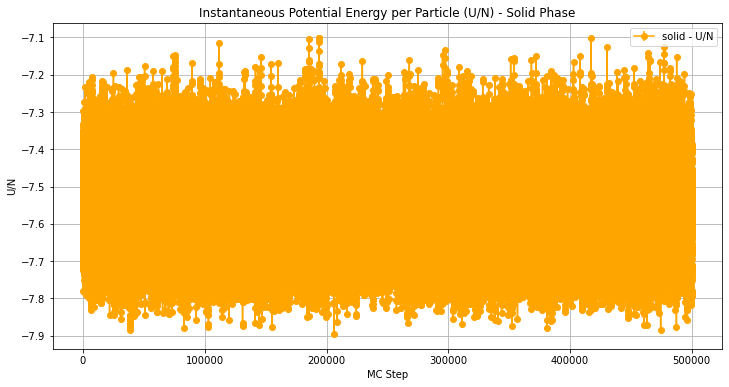

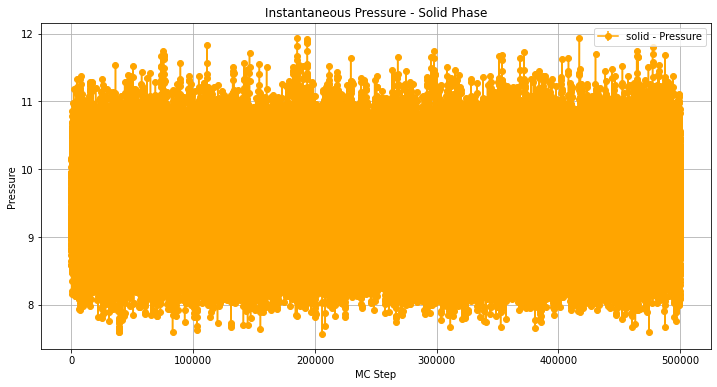

Esecuzione di ./simulator.exe...

Valori istantanei salvati in instantaneous_liquid.dat


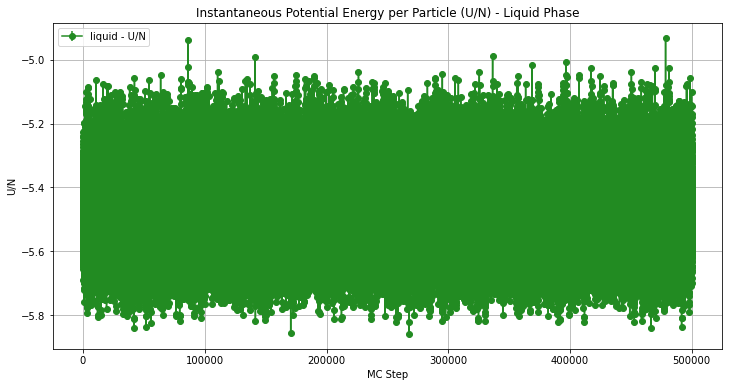

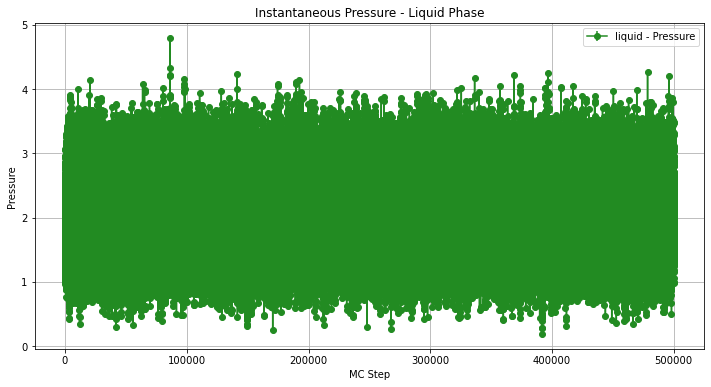

Esecuzione di ./simulator.exe...

Valori istantanei salvati in instantaneous_gas.dat


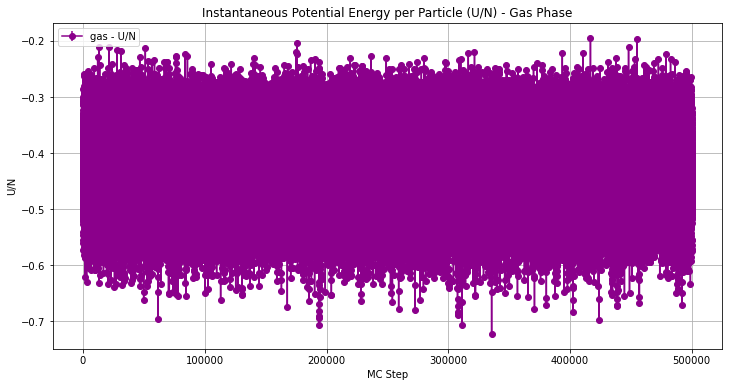

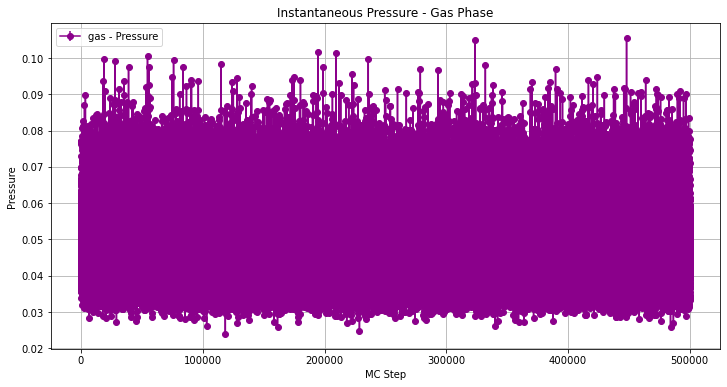

In [8]:
def esegui_file_exe(percorso_exe):
    """Esegue un file .exe specificato."""
    if not os.path.exists(percorso_exe):
        print(f"Errore: Il percorso {percorso_exe} non esiste.")
        return False
    try:
        print(f"Esecuzione di {percorso_exe}...")
        result = subprocess.run(percorso_exe, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode())
        return True
    except subprocess.CalledProcessError as e:
        print(f"Errore durante l'esecuzione: {e.stderr.decode()}")
        return False

def modifica_parametro(file_path, parametro, nuovo_valore):
    """Modifica un parametro specificato in un file di input."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for i, line in enumerate(lines):
        if parametro in line:
            lines[i] = f"{parametro} {nuovo_valore}\n"
            break
    with open(file_path, 'w') as file:
        file.writelines(lines)

def leggi_valori_istantanei(percorso, colonna_valore, colonna_errore):
    """Legge i valori istantanei e gli errori dai file specificati."""
    valori = []
    errori = []
    if not os.path.exists(percorso):
        print(f"Errore: Il file {percorso} non esiste.")
        return valori, errori
    with open(percorso, 'r') as file:
        for line in file:
            if line.startswith("#") or not line.strip():
                continue  # Salta intestazioni o righe vuote
            valori_linea = line.split()
            if len(valori_linea) >= max(colonna_valore, colonna_errore) + 1:
                valori.append(float(valori_linea[colonna_valore]))
                errori.append(float(valori_linea[colonna_errore]))
    return valori, errori


def stampa_e_plotta_valori_istantanei(fase, parametri, percorso_input, percorso_exe, percorsi_output, file_output, colori_fasi):
    """Simula una fase, stampa e plotta i valori istantanei di U/N e pressione con errori."""
    # Modifica parametri termodinamici
    for parametro, valore in parametri.items():
        modifica_parametro(percorso_input, parametro, valore)
    
    # Esegui simulazione
    if not esegui_file_exe(percorso_exe):
        print(f"Simulazione per la fase {fase} fallita.")
        return None

    # Leggi valori istantanei di energia e pressione
    valori_energia, errori_energia = leggi_valori_istantanei(
        percorsi_output['energia'], colonna_valore=1, colonna_errore=3
    )
    valori_pressione, errori_pressione = leggi_valori_istantanei(
        percorsi_output['pressione'], colonna_valore=1, colonna_errore=3
    )
    
    if not valori_energia or not valori_pressione:
        print(f"Errore: I valori istantanei per la fase {fase} non sono stati generati correttamente.")
        return None

    # Salva valori in un file di output
    with open(file_output, 'w') as file:
        file.write("# Step\tU/N\tErrore U/N\tPressione\tErrore Pressione\n")
        for i, (energia, errore_energia, pressione, errore_pressione) in enumerate(
            zip(valori_energia, errori_energia, valori_pressione, errori_pressione), start=1
        ):
            file.write(f"{i}\t{energia}\t{errore_energia}\t{pressione}\t{errore_pressione}\n")
    
    print(f"Valori istantanei salvati in {file_output}")
    
    # Plot dei valori istantanei di U/N con errore
    steps = range(1, len(valori_energia) + 1)
    plt.figure(figsize=(12, 6))
    plt.errorbar(steps, valori_energia, yerr=errori_energia, fmt='o-', label=f'{fase} - U/N', color=colori_fasi)
    plt.title(f"Instantaneous Potential Energy per Particle (U/N) - {fase.capitalize()} Phase")
    plt.xlabel("MC Step")
    plt.ylabel("U/N")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot dei valori istantanei di pressione con errore
    plt.figure(figsize=(12, 6))
    plt.errorbar(steps, valori_pressione, yerr=errori_pressione, fmt='o-', label=f'{fase} - Pressure', color=colori_fasi)
    plt.title(f"Instantaneous Pressure - {fase.capitalize()} Phase")
    plt.xlabel("MC Step")
    plt.ylabel("Pressure")
    plt.legend()
    plt.grid()
    plt.show()

    return valori_energia, valori_pressione

# Parametri di simulazione
percorso_input = "../INPUT/input.dat"  # File di input del simulatore
percorso_exe = "./simulator.exe"  # File eseguibile del simulatore
percorsi_output = {
    'energia': "../OUTPUT/potential_energy.dat",
    'pressione': "../OUTPUT/pressure.dat"
}

fasi = {
    "solid": {"TEMP": 0.8, "RHO": 1.1, "R_CUT": 2.2, "DELTA": 0.05},
    "liquid": {"TEMP": 1.1, "RHO": 0.8, "R_CUT": 2.5, "DELTA": 0.1},
    "gas": {"TEMP": 1.2, "RHO": 0.05, "R_CUT": 5.0, "DELTA": 7.0}
}

colori_fasi = {
    "solid": "orange",
    "liquid": "forestgreen",
    "gas": "darkmagenta"
}

# Simula ciascuna fase e stampa i valori istantanei
for fase, parametri in fasi.items():
    file_output = f"instantaneous_{fase}.dat"
    #plot_output_energia = f"plot_instantaneous_{fase}_energy.png"
    #plot_output_pressione = f"plot_instantaneous_{fase}_pressure.png"
    stampa_e_plotta_valori_istantanei(
        fase,
        parametri,
        percorso_input,
        percorso_exe,
        percorsi_output,
        file_output,
        #plot_output_energia,
        #plot_output_pressione,
        colori_fasi[fase]
    )

## Autocorrelation 

Since the Metropolis algorithm shows high correlation among data it is very important to take actions that aim to avoid that final results are affected by this limit.

This is why we basically need to measure the correlation MC-time $t_c$: it is the MC-time interval (i.e. MC-steps) $t_c=t_f-t_i$ in which we can reach no correlation between the first observable measurement $x(t_i)$ and the final one $x(t_f)$.

In order to evaluate $t_c$ we need the autocorrelation function $\chi (t)$, defined as follows:

$ \chi(t)=\frac{\langle x(\bar{t} ) \cdot x(\bar{t}+t  ) \rangle -\langle x( \bar{t}  ) \rangle \cdot \langle x( \bar{t}+ t  ) \rangle }{\sigma_ x^2}$

where $t= \Delta t$ is the MC time between two consecutive measurements $x(t_i)=x(\bar{t})$ and $x(t_f)=x(t_i +\Delta t) = x(\bar{t}+t)$.

It is easy to understand that when there is high correlation between the two measurements, $\chi(t)$ is large and positive, whereas it tends to zero when the two measurements are evaluated at two times long away apart. So we expect an exponential behaviour:

$\chi (t) \approx e ^{- \frac{t}{t_c}}$

In this way we are provided of a method to evaluate $t_c$. Of course if $t=t_c$ the autocorrelation is decreased of a factor ($e^{-1}$), but it is not so close to zero; so it is conventionally chosen as a proper MC step $t=2 t_c$

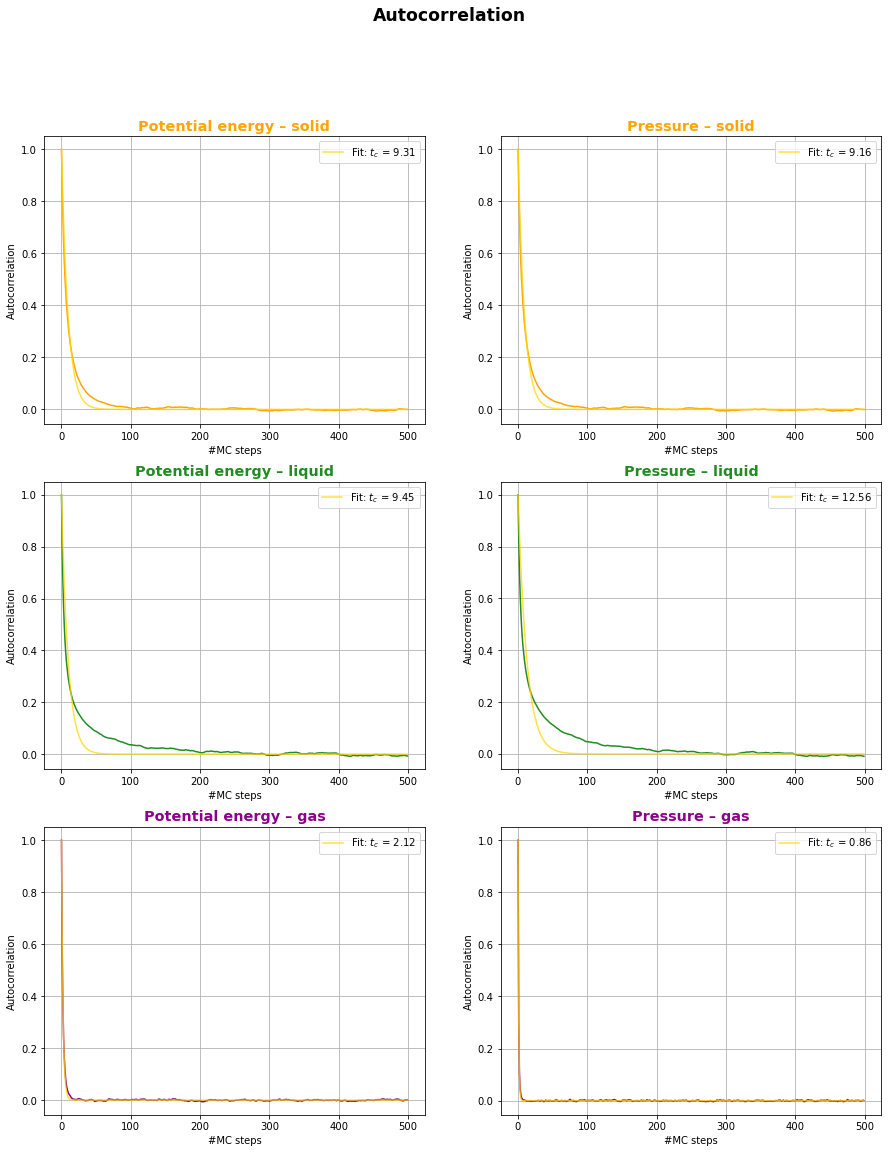

In [15]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Funzione di autocorrelazione
def f(x, t_c):
    return np.exp(-x/t_c)

def autocorrelation(x, steps):
    autoc = np.zeros(steps)
    sigma = np.std(x)
    t_max = len(x)
    
    for dt in range(steps):
        n1 = n2 = n3 = 0.0
        t_tot = t_max - dt
        for t in range(t_tot):
            n1 += x[t] * x[t + dt]
            n2 += x[t]
            n3 += x[t + dt]
        autoc[dt] = (n1 / t_tot - (n2 * n3) / (t_tot**2)) / (sigma**2)
    return autoc

# Plot della figura
fig = plt.figure(figsize=(15, 18))
plt.suptitle("Autocorrelation", size='xx-large', weight='bold')

titles = ['Potential energy', 'Pressure']
columns = [1, 3]  # Indici delle colonne da usare per ogni `a`

t_steps = 500
for a in range(2):  # 0 per U/N, 1 per Pressione
    for i, fase in enumerate(fasi):  # Loop sulle fasi (solid, liquid, gas)
        plt.subplot(3, 2, i * 2 + 1 + a)
        
        # Caricamento dei dati
        y = np.loadtxt(f"instantaneous_{fase}.dat", skiprows=1)  # Salta l'intestazione
        y = y[:, columns[a]]  # Seleziona la colonna basata su `a`
        
        # Calcola l'autocorrelazione
        auto = autocorrelation(y, t_steps)
        plt.plot(auto, color=colori_fasi[fase])
        
        # Fitting
        x = np.arange(t_steps)
        popt, pcov = curve_fit(f, x, auto)
        plt.plot(x, f(x, *popt), label=f"Fit: $t_c$ = {popt[0]:.2f}", color='gold', alpha=0.75)
        
        # Configurazione del plot
        plt.ylabel("Autocorrelation")
        plt.xlabel('#MC steps')
        plt.title(f"{titles[a]} – {fase}", color=colori_fasi[fase], size='x-large', weight='bold')
        plt.grid(True)
        plt.legend()

# Mostra il grafico
plt.show()


## Statistical error

We are now going to estimate the error as the standard deviation of the mean, when considering different size of the blocks $L$

$\sigma=\sqrt{\frac{\langle x^{2}\rangle - \langle x\rangle^{2}}{N-1}} $

where $N=M/L$, $M=10^{5}$ and $L \in [10, 5 \cdot 10^{3}]$

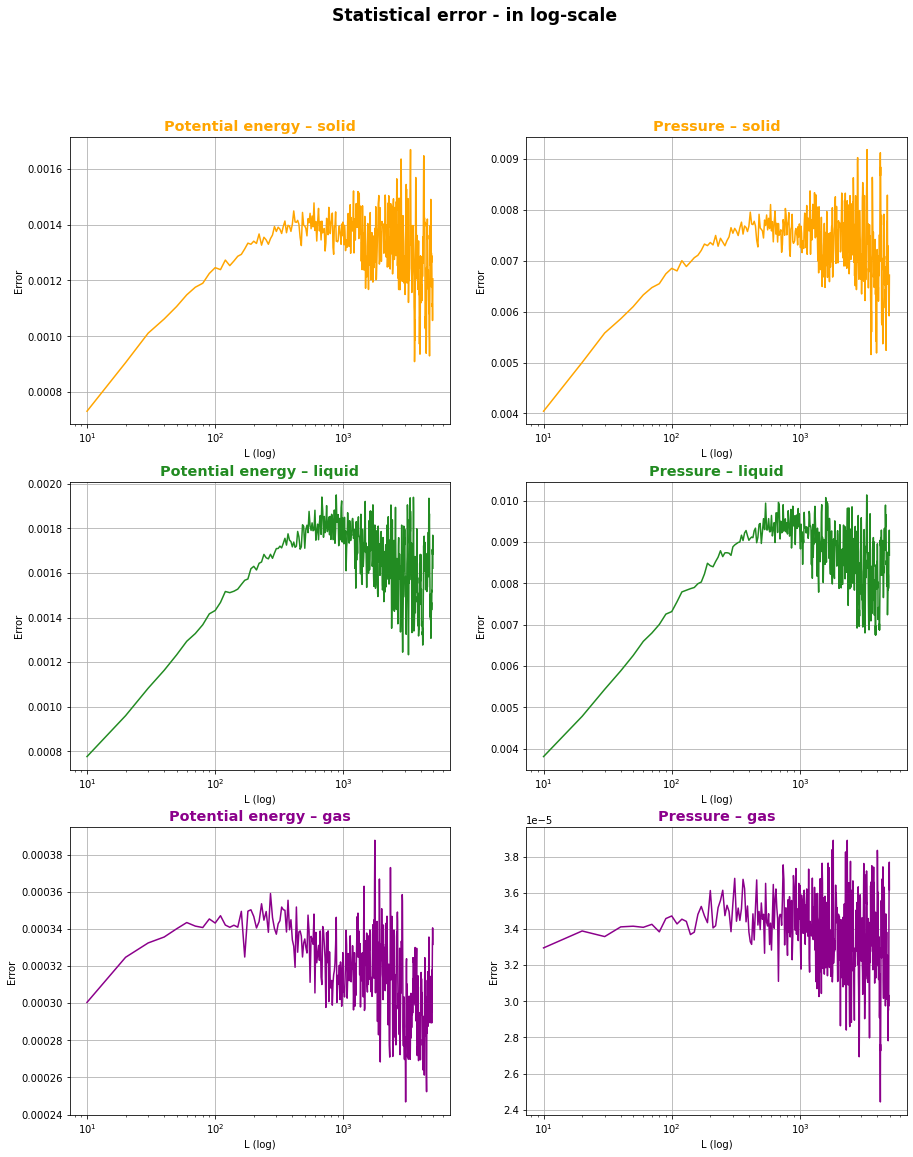

In [17]:
def Error(ave, ave2, n):
    if(n==0): 
        return 0.0
    else: 
        return np.sqrt((ave2-ave**2)/n)

def data_blocking(x, N, L):
    mean=mean2=error=0.0
    for n in range(N):
        mean_block=0.0
        mean2_block=0.0
        for l in range(L):
            mean_block+=x[l+n*L]
        mean_block/=L
        mean=(mean*n+mean_block)/(n+1)
        mean2=(mean2*n+mean_block**2)/(n+1)
        error=Error(mean, mean2,n)
    return mean, error #lascio mean per completezza

L_m=10
L_M=5000
M=100000
L_step=10
L_steps=int((L_M-L_m)/L_step)

fig=plt.figure(figsize=(15, 18))
plt.suptitle("Statistical error - in log-scale", size='xx-large', weight='bold')

for a in range(2):
    for i, fase in enumerate(fasi):
        plt.subplot(3,2,i*2+1+a)

        # Caricamento dei dati
        y = np.loadtxt(f"instantaneous_{fase}.dat", skiprows=1)  # Salta l'intestazione
        y = y[:, columns[a]]  # Seleziona la colonna basata su `a`
        

        error=[]
        x=[]
        for l in range(L_steps):
            L=L_m+l*L_step
            N=int(M/L)
            mean, err=data_blocking(y,N,L)
            error.append(err)
            x.append(L)
        plt.plot(x, error, color=colori_fasi[fase])
        
        plt.ylabel("Error")
        plt.xlabel('L (log)')
        plt.xscale("log")
        plt.title(f"{titles[a]} – {fase}", color=colori_fasi[fase], size='x-large', weight='bold')
        plt.grid(True)
        
plt.show()


We notice that there is a first interval where the error increases monotonically with the block size, while for $L \geq 200$ a stationary behaviour is shown. This is another useful indication for choosing a proper value of $L$. In order to have uncorrelated indipendent variables and to apply the Central Limit Theorem, we should find that decreasing the number of blocks $N$ (i.e. increasing the size of each block $L$) after at a certain value would not lead to increase in error bar width as well. This is the threshold value we are looking for.

## 7.3 - Radial distribution function

In this exercise we are asked to include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

## 7.4 - Argon

In the last exercise we are asked to evaluate the results in the real cases of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

performing MC NVT simulations via Lennard-Jones model

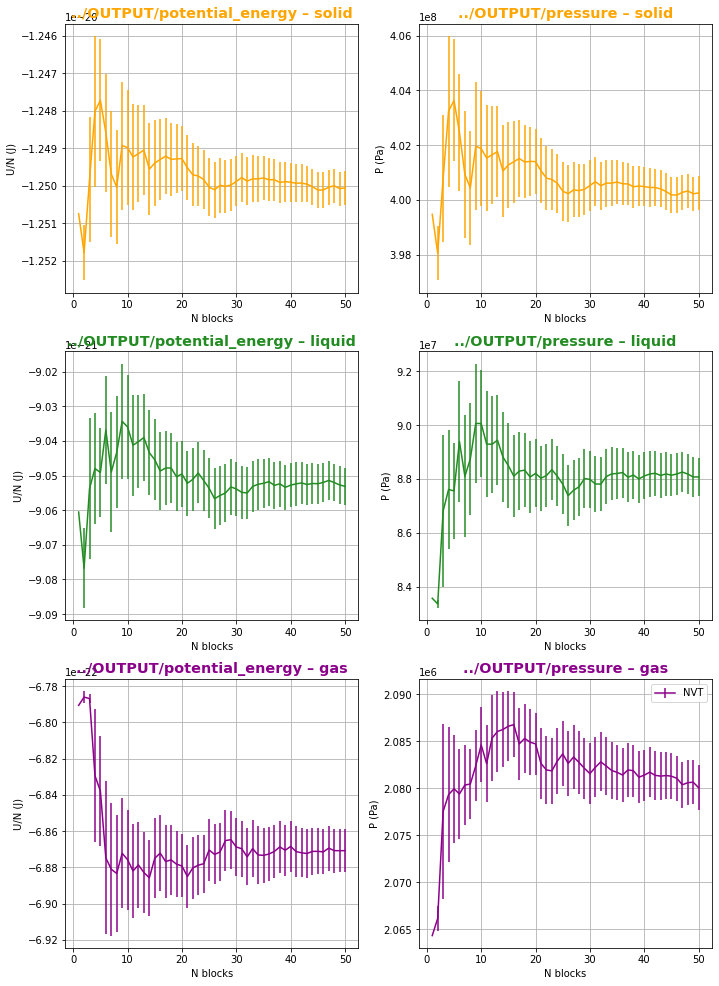

In [ ]:
#parameters for SI
kb=1.38064852E-23
amu=1.66054E-24
nm=1.0E-9

sigma=0.34*nm
epsilon_kb=120
epsilon=120*kb
mass=39.948*amu

fp=[]
fp.append(epsilon/sigma/sigma/sigma)

#phases=['solid','liquid','gas']
axis2=['U/N (J)', 'P (Pa)']
output2=['potential_energy_NVT','pression_NVT',]
titles2=['../OUTPUT/potential_energy', '../OUTPUT/pressure']

#plot data
fig=plt.figure(figsize=(15, 15))
plt.title("Argon", size='xx-large', weight='bold')

    #1)Potential energy
    #2)Pressure
for a in range(2): #cyclew over observables
    for i, (fase, parametri) in enumerate(fasi.items()):  # Ciclo su fasi
        # Modifica parametri nel file input.dat
        for parametro, valore in parametri.items():
            modifica_parametro(percorso_input, parametro, valore)  # Implementata esternamente

        # Esegui la simulazione
        subprocess.run(["./simulator.exe"], check=True)  # Adatta con il tuo comando
        
        #plot
        plt.subplot(3,3,a+i*3+1)
        x, y, err = np.loadtxt(titles2[a]+".dat", usecols=(0,2,3),unpack=True)
        
        #conversione delle unità
        if (a==0):
            conv=epsilon
        elif (a==1):
            conv=fp
        y*=conv
        err*=conv

        plt.errorbar(x,y,yerr=err, color=colori_fasi[fase], label='NVT')
        plt.ylabel(axis2[a])
        plt.xlabel('N blocks')
        plt.title(f"{titles2[a]} – {fase}", color=colori_fasi[fase], size='x-large', weight='bold')
        plt.grid(True)

        # Mostra il grafico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Migliora margini
plt.show()


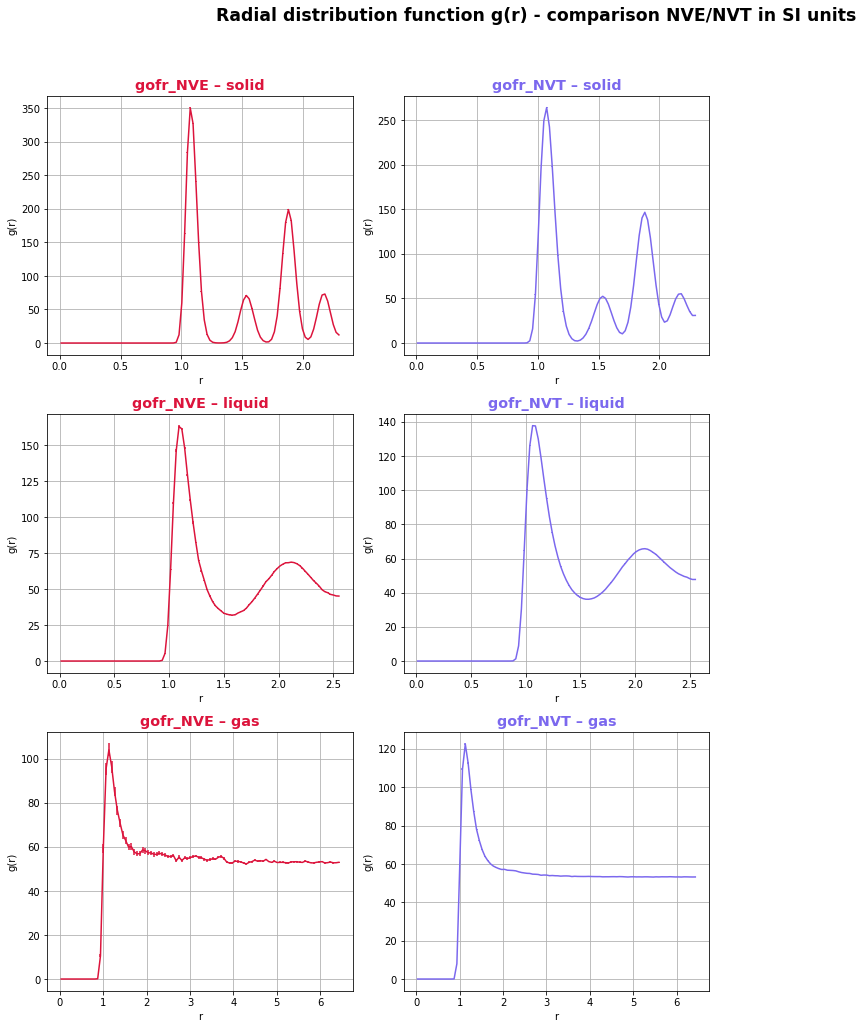

In [19]:
#simulation=[0,1]
colori_gofr=['crimson', 'mediumslateblue']
titles_gofr=['gofr_NVE', 'gofr_NVT']
fasi_gofr = {
    "solid": {"TEMP": 0.8, "RHO": 1.1, "R_CUT": 2.2}, # 0=1 0.0005
    "liquid": {"TEMP": 1.1, "RHO": 0.8, "R_CUT": 2.5}, # 0 0.0005 1 0.5
    "gas": {"TEMP": 1.2, "RHO": 0.05, "R_CUT": 5.0} # 0 0.0005 1 7.5
}
delta=[{}]
percorso_input = "../INPUT/input.dat"  # File di input del simulatore
percorso_exe = "./simulator.exe"  # File eseguibile del simulatore

delta_dict = {'solid': [0.0005,0.05], 'liquid': [0.0005,0.1], 'gas': [0.0005,7.5]}

#plot data
fig=plt.figure(figsize=(15, 15))
plt.suptitle("Radial distribution function g(r) - comparison NVE/NVT in SI units", size='xx-large', weight='bold')

for a in range(2): #cycle over simulation type
    for i, (fase, parametri) in enumerate(fasi_gofr.items()):  # Ciclo su fasi
        # Modifica parametri nel file input.dat
        for parametro, valore in parametri.items():
            modifica_parametro(percorso_input, parametro, valore)  # Implementata esternamente
        modifica_parametro(percorso_input, "DELTA", delta_dict[fase][a] )
        modifica_parametro(percorso_input, "SIMULATION_TYPE", a)
        

        # Esegui la simulazione
        subprocess.run(["./simulator.exe"], check=True)  # Adatta con il tuo comando
        
        #plot
        plt.subplot(3,3,a+i*3+1)
        x, y, err = np.loadtxt('../OUTPUT/gofr.dat', usecols=(0,1,2),unpack=True)

        plt.errorbar(x,y,yerr=err, color=colori_gofr[a], label=titles_gofr[a])
        plt.ylabel('g(r)')
        plt.xlabel('r')
        plt.title(f"{titles_gofr[a]} – {fase}", color=colori_gofr[a], size='x-large', weight='bold')
        plt.grid(True)

        # Mostra il grafico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Migliora margini
plt.show()